In [1]:
# import required libraries required
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score
import time


pd.set_option('display.max_columns', 999)

In [2]:
#Read merged dataset in csv format
#This dataset has element of time series, we have splitted the train data w.r.t year.
# we have train, validation and test dataset
df =pd.read_csv('../data/train_070911.csv') 
df_val=pd.read_csv('../data/train2013.csv')
df_test=pd.read_csv('../data/weather_test_merged.csv')


In [3]:
# sanity shape of train/val/test shape
print(df.shape)
print(df_val.shape)
print(df_test.shape)

(6552, 67)
(2058, 67)
(116293, 66)


In [4]:
#drop cols for train set
target_df = df['WnvPresent']
drop_columns = ['Date','Trap','NumMosquitos','month','year_month','WnvPresent','carrier','Latitude','Longitude','week_y','Station','station','Sunrise',
                'Sunset','sunrise_clean','sunset_clean','month','year_y','day','WetBulb','Tmin','Tmax','ResultDir']

df.drop(columns = drop_columns,inplace=True)

In [5]:
# drop cols for val set
target_dfval = df_val['WnvPresent']
drop_columns = ['Date','NumMosquitos','Trap','month','year_month','WnvPresent','carrier','Latitude','Longitude','week_y','Station','station','Sunrise',
                'Sunset','sunrise_clean','sunset_clean','month','year_y','day','WetBulb','Tmin','Tmax','ResultDir']
df_val.drop(columns = drop_columns,inplace=True)

In [6]:
#drop cols for test set
drop_columns = ['Date','Trap','month','year_month','carrier','Latitude','Longitude','week_y','Station','station','Sunrise',
                'Sunset','sunrise_clean','sunset_clean','month','year_y','day','WetBulb','Tmin','Tmax','ResultDir']
df_test = df_test[list(df_test.columns.values)]

df_test.drop(columns = drop_columns,inplace=True)

In [7]:
# sanity check to ensure shape integrity 
print(df.shape)
print(df_val.shape)
print(df_test.shape)

(6552, 45)
(2058, 45)
(116293, 46)


In [8]:
##variable assignment
X_train=df
X_test= df_val
y_train=target_df
y_test=target_dfval



## Synthetic Minority Oversampling TEchnique a.k.a Smote

Classification using class-imbalanced data is biased in favor of the majority class. The bias is even larger for high-dimensional data, where the number of variables greatly exceeds the number of samples. The problem can be attenuated by undersampling or oversampling, which produce class-balanced data. In the below scenario, we have chose to use smote to counter this imbalanced data biasness.

ytrain imbalanced:


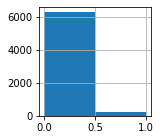

In [9]:
# it was clearly evident that there was an imblance data
print('ytrain imbalanced:')
p=y_train.hist(figsize=(2,2),bins=2)

ytrain balanced:


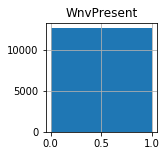

In [10]:
# balance and show the output after smote 
smt=SMOTE(random_state=42)
smtXtrain,smtytrain=smt.fit_sample(X_train,y_train)
print('ytrain balanced:')
p=pd.DataFrame((smtytrain)).hist(figsize=(2,2),bins=1)

In [11]:
# function for scoring metrics
def eval_metrics(y_true, predictions, model=None, X=None):

    cnf_matrix = confusion_matrix(y_true, predictions)

    print('True Negative: ', cnf_matrix[0, 0], '| False Positive: ', cnf_matrix[0, 1])
    print('False Negative: ', cnf_matrix[1, 0], '| True Positive: ', cnf_matrix[1, 1], '\n')

    sensitivity = cnf_matrix[1, 1]/ (cnf_matrix[1, 0] + cnf_matrix[1, 1])
    specificity = cnf_matrix[0, 0]/ (cnf_matrix[0, 1] + cnf_matrix[0, 0])

    print('Sensitivity (TP/ TP + FN): ', sensitivity)
    print('Specificity (TN/ TN + FP): ', specificity, '\n')

    print('Accuracy: ', accuracy_score(y_true, predictions, normalize=True))
    print('Precision: ', precision_score(y_true, predictions))
    if model != None:
        print('Roc-Auc: ', roc_auc_score(y_true, [x[1] for x in model.predict_proba(X)]))
    else:
        pass
    print('\n')

##  Model for ExtraTrees

In [12]:
# ET model and score with val set
%time
etc = ExtraTreesClassifier(class_weight='balanced', max_features='sqrt', min_samples_leaf=5, n_estimators=100, n_jobs=-1)
etc.fit(smtXtrain, smtytrain)
test_predictions = etc.predict(X_test)
print('Extra Trees TEST SCORE:\n')
eval_metrics(y_test, test_predictions,model=etc,X=X_test)


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs
Extra Trees TEST SCORE:

True Negative:  1459 | False Positive:  400
False Negative:  94 | True Positive:  105 

Sensitivity (TP/ TP + FN):  0.5276381909547738
Specificity (TN/ TN + FP):  0.7848305540613233 

Accuracy:  0.7599611273080661
Precision:  0.2079207920792079
Roc-Auc:  0.7508778426830224




## Model for RandomForestClassifier

In [13]:
# RF model and score with val set

%time
rfc = RandomForestClassifier(class_weight='balanced', max_features='sqrt', min_samples_leaf=5, n_estimators=1000, n_jobs=-1)
rfc.fit(smtXtrain, smtytrain)
test_predictions = rfc.predict(X_test)
print('Random Forest TEST SCORE:\n')
eval_metrics(y_test, test_predictions,model=rfc,X=X_test)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
Random Forest TEST SCORE:

True Negative:  1526 | False Positive:  333
False Negative:  109 | True Positive:  90 

Sensitivity (TP/ TP + FN):  0.45226130653266333
Specificity (TN/ TN + FP):  0.8208714362560516 

Accuracy:  0.7852283770651117
Precision:  0.2127659574468085
Roc-Auc:  0.7498939020005893




## Gridsearch

In this section, we have performed Gridsearch on both classifier to get the optimal parameters for respective classifier.

### For ExtraTrees

In [14]:
# ExtraTrees GridSearch for best params

start_time = time.time()

#  estimators 
param_grid = dict(n_estimators = [100, 1000],
                 max_depth=[3,4,5],
                 min_samples_leaf = [2, 3, 4, 5, 6]
                 )
# Cross val
cross_val=3
#ExtraTrees Classifer model
model = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

#Gridsearch
grid = GridSearchCV(model, param_grid, cv=cross_val, scoring='roc_auc', verbose=1)

grid.fit(smtXtrain, smtytrain)

best_results = {'params': list(grid.best_params_.items()), 'score': grid.best_score_}
#re-fit model with optimize best estimator for ET
best_model = grid.best_estimator_

best_model = best_model.fit(smtXtrain, smtytrain)

score = best_model.score(X_test, y_test)

#print Gridsearch results
print('Number of Models Run: ', np.prod([len(param_grid[i]) for i in param_grid]) * cross_val)
print("{} Score: {:0.3}".format('Extra Tree Classifier', score.mean().round(3)), '\n')
print('Elapsed Time: {:0.3}'.format( time.time() - start_time), ' seconds', '\n')
print(grid.best_estimator_, '\n')
print('Best Hyperparameters we tested for', '\n', best_results)


#for Extra Tree train/val score
test_predictions = best_model.predict(X_test)
print('Grid Search TEST SCORE:\n')
eval_metrics(y_test, test_predictions, model=best_model, X=X_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.8min finished


Number of Models Run:  90
Extra Tree Classifier Score: 0.756 

Elapsed Time: 1.1e+02  seconds 

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=4, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=4, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False) 

Best Hyperparameters we tested for 
 {'params': [('max_depth', 4), ('min_samples_leaf', 4), ('n_estimators', 100)], 'score': 0.8368187294147013}
Grid Search TEST SCORE:

True Negative:  1456 | False Positive:  403
False Negative:  100 | True Positive:  99 

Sensitivity (TP/ TP + FN):  0.49748743718592964
Specificity (TN/ TN + FP):  0.7832167832167832 

Accuracy:  0.7

In [15]:
# Randomforest GridSearch for best params
start_time = time.time()

#  estimators 
param_grid = dict(n_estimators = [100, 1000],
                 max_depth=[3,4,5],
                 min_samples_leaf = [2, 3, 4, 5, 6]
               )
#cross val
cross_val=3

model_rf = RandomForestClassifier(class_weight='balanced')
#Gridsearch

grid_rf = GridSearchCV(model_rf, param_grid, cv=cross_val, scoring='roc_auc', verbose=1)

grid_rf.fit(smtXtrain, smtytrain)

best_results_rf = {'params': list(grid_rf.best_params_.items()), 'score': grid_rf.best_score_}

#re-fit model with optimize best estimator for RF

best_model_rf = grid_rf.best_estimator_

best_model_rf = best_model_rf.fit(smtXtrain, smtytrain)

score_rf = best_model_rf.score(X_test, y_test)

#print Gridsearch results
print('Number of Models Run: ', np.prod([len(param_grid[i]) for i in param_grid]) * cross_val)
print("{} Score: {:0.3}".format('Random Tree Classifier', score_rf.mean().round(3)), '\n')
print('Elapsed Time: {:0.3}'.format( time.time() - start_time), ' seconds', '\n')
print(grid_rf.best_estimator_, '\n')
print('Best Hyperparameters we tested for', '\n', best_results_rf)

# for RandomTree train/val score
test_predictions_rf = best_model_rf.predict(X_test)
print('Grid Search TEST SCORE:\n')
eval_metrics(y_test, test_predictions_rf, model=best_model_rf, X=X_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.8min finished


Number of Models Run:  90
Random Tree Classifier Score: 0.773 

Elapsed Time: 2.27e+02  seconds 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

Best Hyperparameters we tested for 
 {'params': [('max_depth', 4), ('min_samples_leaf', 4), ('n_estimators', 100)], 'score': 0.811229535111897}
Grid Search TEST SCORE:

True Negative:  1497 | False Positive:  362
False Negative:  105 | True Positive:  94 

Sensitivity (TP/ TP + FN):  0.4723618090452261
Specificity (TN/ TN + FP):  0.8052716514254976

## Feature evaluation

In [16]:
# ExtraTree top 10 features
feature_import = best_model.feature_importances_
features = df.columns
features_et=pd.DataFrame(columns=['feature', 'importance'], 
             data=list(zip(features, feature_import))).sort_values('importance',ascending=False)
features_et.head(10)

,feature,importance
7,species_restuans,0.136183
0,jul,0.112191
39,DaylightHrs_lag_3,0.095654
38,DaylightHrs_lag_1,0.084396
37,DaylightHrs,0.079628
1,jun,0.071317
40,DaylightHrs_lag_7,0.070182
13,DewPoint,0.042903
15,Cool,0.034260
12,Tavg,0.023069


In [17]:
# RandomTree top 10 feature 
feature_import_rf = best_model_rf.feature_importances_
features = df.columns
features_rf= pd.DataFrame(columns=['feature', 'importance'], 
             data=list(zip(features, feature_import_rf))).sort_values('importance',ascending=False)
features_rf.head(10)

,feature,importance
38,DaylightHrs_lag_1,0.135440
40,DaylightHrs_lag_7,0.125597
39,DaylightHrs_lag_3,0.102975
7,species_restuans,0.085527
0,jul,0.067690
13,DewPoint,0.055799
37,DaylightHrs,0.054549
1,jun,0.038197
21,AvgSpeed,0.036365
15,Cool,0.033981


### Testing with test data

In [18]:
# in order for columns to match, we set Id as index 
df_test.set_index('Id',inplace=True)

In [19]:
##ExtraTrees
#assigning predict probab into pred variable
pred = best_model.predict_proba(df_test)
pred=[i[1] for i in pred]

In [20]:
## RandomForest
#assigning predict probab into pred_rf variable
pred_rf = best_model_rf.predict_proba(df_test)
pred_rf=[i[1] for i in pred_rf]

In [21]:
#assigning pred into 'WnvPresent' for kaggle submission
final=pd.DataFrame(df_test.index,columns=['Id'])
final['WnvPresent']=pred

In [22]:
#assigning pred_rf into 'WnvPresent' for kaggle submission
final_rf=pd.DataFrame(df_test.index,columns=['Id'])
final_rf['WnvPresent']=pred_rf

In [23]:
#output into csv
final.to_csv('../data/submission_new_et.csv',index=False)
final_rf.to_csv('../data/submission_new_rf.csv',index=False)


### Model Evaluation

We have performed modelling with ExtraTrees, Random Forest, Support Vector Machine and XGBoost classifier. Through this modelling process, we have scored the performance of the various models on Kaggle. Based on the highest ROC-AUC score, we have selected ExtraTrees Classifier as our model.

|                            | ExtraTrees | Random Forest | XGBoost |  SVM  |
| :------------------------: | :--------: | :-----------: | :-----: | :---: |
|       ROC-AUC Score        |   0.745    |     0.737     |  0.724  | 0.715 |
| Performance on Unseen Data |   0.687    |     0.669     |  0.683  | 0.642 |

### Conclusion




Based on our study, we had a reasonable prediction of WNV presence by trap. By performing cost-benefit analysis, we uncovered the estimated cost for spray versus medical cost and productivity loss in the public. Asides that, West Nile Virus is not the only disease which mosquitoes carries. We encourage that public needs to be aware of other  diseases which mosquitoes carries and its health threats.